# Attempt to use XGBoost model for forecasting

In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('../data/df_fuel_ckan.csv')
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df_monthly = df.set_index('DATETIME')['CARBON_INTENSITY'].resample('ME').mean().reset_index()

In [18]:
def create_features(df):
    df = df.copy()
    # Seasonal Lags: 1 month, 2 months, and 12 months (yearly seasonality)
    for l in [1, 2, 3, 12]:
        df[f'lag_{l}'] = df['CARBON_INTENSITY'].shift(l)
    
    df['month'] = df['DATETIME'].dt.month
    df['year'] = df['DATETIME'].dt.year
    return df

df_features = create_features(df_monthly).dropna()

In [19]:
train = df_features[df_features['year'] <= 2024]
val = df_features[df_features['year'] == 2025]

X_train = train.drop(columns=['DATETIME', 'CARBON_INTENSITY'])
y_train = train['CARBON_INTENSITY']
X_val = val.drop(columns=['DATETIME', 'CARBON_INTENSITY'])
y_val = val['CARBON_INTENSITY']

In [20]:
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [21]:
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
print(f"Validation MSE for 2025: {mse:.4f}")

Validation MSE for 2025: 596.7138


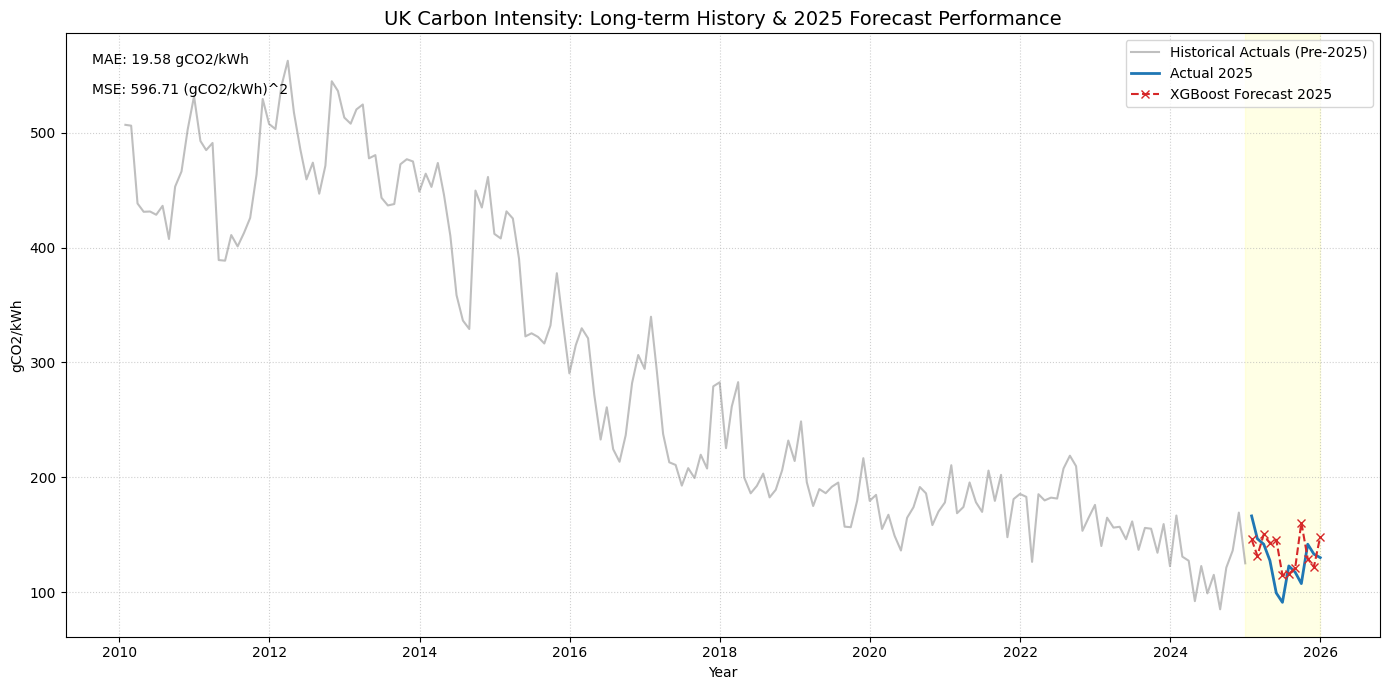

In [22]:
plt.figure(figsize=(14, 7))

plt.plot(train['DATETIME'], train['CARBON_INTENSITY'], 
         color='gray', alpha=0.5, label='Historical Actuals (Pre-2025)')

plt.plot(val['DATETIME'], val['CARBON_INTENSITY'], 
         color='tab:blue', linewidth=2, label='Actual 2025')

plt.plot(val['DATETIME'], y_pred, 
         color='tab:red', linestyle='--', marker='x', label='XGBoost Forecast 2025')

plt.title('UK Carbon Intensity: Long-term History & 2025 Forecast Performance', fontsize=14)
plt.xlabel('Year')
plt.ylabel('gCO2/kWh')
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)

# Highlight the Forecast region
plt.axvspan(pd.Timestamp('2025-01-01'), pd.Timestamp('2025-12-31'), 
            color='yellow', alpha=0.1, label='Forecast Window')
plt.text(0.02, 0.95, "MAE: {:.2f} gCO2/kWh".format(mae), 
         fontsize=10, color='black', transform=plt.gca().transAxes)
plt.text(0.02, 0.90, "MSE: {:.2f} (gCO2/kWh)^2".format(mse), 
         fontsize=10, color='black', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()